In [1]:
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
import numpy as np
from datetime import timedelta, datetime
import time
import networkx as nx
import matplotlib.pyplot as plt
import folium
import warnings
import sys

warnings.filterwarnings('ignore')

print("Geopandas has version {}".format(gpd.__version__))
print("Movingpandas has version {}".format(mpd.__version__))

Geopandas has version 0.13.2
Movingpandas has version 0.17.1


In [2]:
eval_df = pd.read_csv('../models/Maritime-Traffic-Network.csv')
eval_df['algorithm'].fillna('V1.0', inplace=True)
#eval_df = eval_df[eval_df['algorithm']=='V2.0']
eval_df.dropna(inplace = True)
eval_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490 entries, 0 to 489
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Id                        490 non-null    object 
 1   Creation Time             490 non-null    object 
 2   Tags                      490 non-null    object 
 3   model                     490 non-null    object 
 4   n_points                  490 non-null    int64  
 5   n_nodes                   490 non-null    int64  
 6   n_edges                   490 non-null    int64  
 7   n_isolated                490 non-null    int64  
 8   DP_tol                    490 non-null    int64  
 9   clustering_alg            490 non-null    object 
 10  min_samples               490 non-null    int64  
 11  metric                    490 non-null    object 
 12  V 1,2                     490 non-null    float64
 13  V 3,4                     490 non-null    float64
 14  V 5       

In [3]:
# parameter summary:
n_points = sorted(eval_df.n_points.unique())
min_samples = sorted(eval_df.min_samples.unique())
v34 = sorted(eval_df['V 3,4'].unique())
v5 = sorted(eval_df['V 5'].unique())
print(f'n_points: {n_points}')
print(f'HDBSCAN min_samples: {min_samples}')
print(f'v34: {v34}')
print(f'v5: {v5}')

n_points: [448382, 796177, 1023428, 1794132, 2173821, 3109329, 4716292, 5422129]
HDBSCAN min_samples: [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 25, 30, 35, 40, 45, 50]
v34: [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
v5: [1e-07, 1e-06, 1e-05, 0.0001, 0.0005, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]


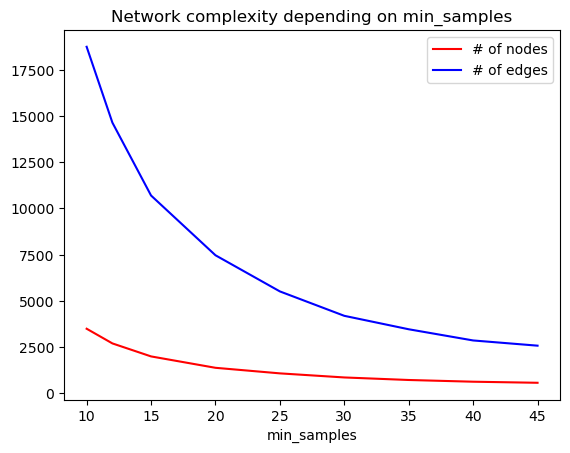

In [4]:
# DEPENDENCE n_edges to min_samples
eval_df.sort_values(by='min_samples', inplace=True)

filter = (eval_df['n_points']==5422129) & (eval_df['V 5']==1e-4) & (eval_df['V 3,4']==1e-2) & (eval_df['test_data/n_trajectories']==752)
x = eval_df[filter]['min_samples']
y1 = eval_df[filter]['n_nodes']
y2 = eval_df[filter]['n_edges']
plt.plot(x, y1, color='red')
plt.plot(x, y2, color='blue')
plt.xlabel('min_samples')
plt.legend(['# of nodes', '# of edges'])

plt.title('Network complexity depending on min_samples')
plt.show()

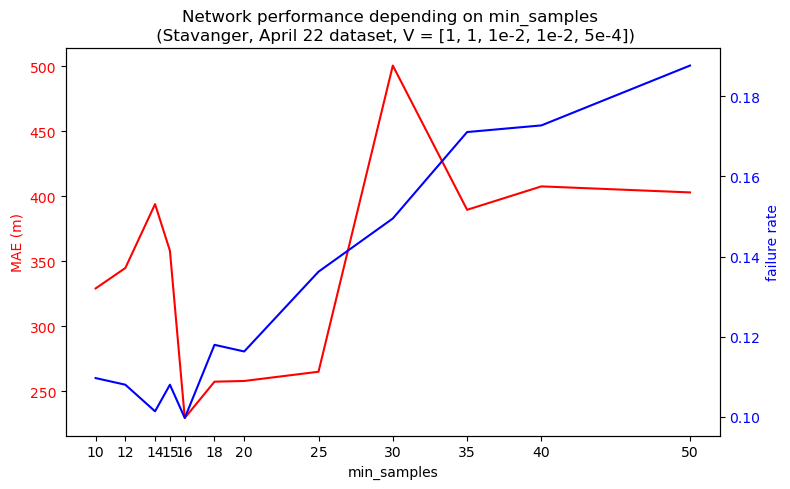

In [5]:
# DEPENDENCE: MIN_SAMPLES (Stavanger)
eval_df.sort_values(by='min_samples', inplace=True)

filter = (eval_df['n_points']==5422129) & (eval_df['V 5']==5e-4) & (eval_df['V 3,4']==1e-2) & (eval_df['algorithm']=='V7.0(SSPD)')
x = eval_df[filter]['min_samples']

fig, ax1 = plt.subplots(figsize=[8, 5])

ax1.set_xlabel('min_samples')
ax1.set_ylabel('MAE (m)', color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax1.set_xticks(x)
ax2 = ax1.twinx()
ax2.set_ylabel('failure rate', color='blue') 
ax2.tick_params(axis='y', labelcolor='blue')

y1 = eval_df[filter]['Mean']
y2 = 1-eval_df[filter]['success']
ax1.plot(x, y1, color='red')
ax2.plot(x, y2, color='blue')

plt.title('Network performance depending on min_samples \n (Stavanger, April 22 dataset, V = [1, 1, 1e-2, 1e-2, 5e-4])')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('min_samples.png')
fig.show()

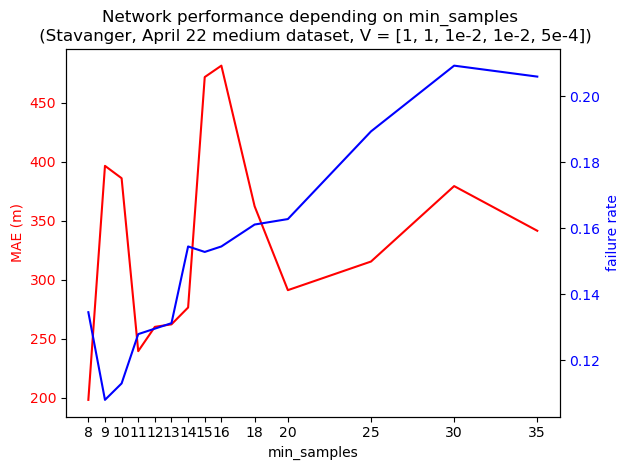

In [6]:
# DEPENDENCE: MIN_SAMPLES medium dataset (Stavanger)
eval_df.sort_values(by='min_samples', inplace=True)
filter = ((eval_df['n_points']==1794132) & (eval_df['V 5']==5e-4) & (eval_df['V 3,4']==1e-2) & (eval_df['algorithm']=='V7.0(SSPD)') 
           & (eval_df['pruning']==1) & (eval_df['DP_tol']==10))
x = eval_df[filter]['min_samples']

fig, ax1 = plt.subplots()

ax1.set_xlabel('min_samples')
ax1.set_ylabel('MAE (m)', color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax1.set_xticks(x)
ax2 = ax1.twinx()
ax2.set_ylabel('failure rate', color='blue') 
ax2.tick_params(axis='y', labelcolor='blue')

y1 = eval_df[filter]['Mean']
y2 = 1-eval_df[filter]['success']
ax1.plot(x, y1, 'r')
ax2.plot(x, y2, 'b')

plt.title('Network performance depending on min_samples \n (Stavanger, April 22 medium dataset, V = [1, 1, 1e-2, 1e-2, 5e-4])')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.show()

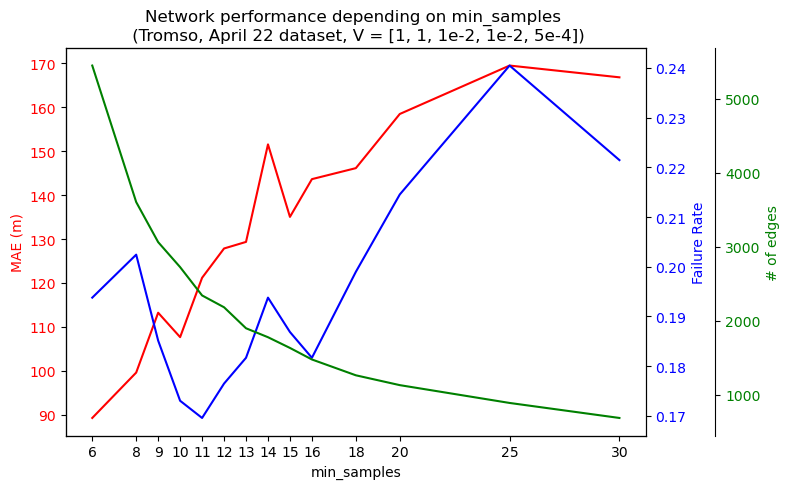

In [7]:
# DEPENDENCE: MIN_SAMPLES (Tromso)
eval_df.sort_values(by='min_samples', inplace=True)

filter = (eval_df['n_points']==796177) & (eval_df['V 5']==5e-4) & (eval_df['V 3,4']==1e-2) & (eval_df['algorithm']=='V7.0(SSPD)') & (eval_df['min_samples']!=7)
x = eval_df[filter]['min_samples']

# configure axes
fig, ax1 = plt.subplots(figsize=[8, 5])
ax1.set_xlabel('min_samples')
ax1.set_ylabel('MAE (m)', color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax1.set_xticks(x)
ax2 = ax1.twinx()  
ax2.set_ylabel('Failure Rate', color='blue') 
ax2.tick_params(axis='y', labelcolor='blue')
ax3 = ax1.twinx()  
#ax3.set_ylabel('Running Time (s)', color='green')
ax3.set_ylabel('# of edges', color='green')
ax3.tick_params(axis='y', labelcolor='green')
ax2.spines['right'].set_position(('outward', 0))  # Adjust the offset as needed
ax3.spines['right'].set_position(('outward', 50))  # Adjust the offset as needed

y1 = eval_df[filter]['Mean']
y2 = 1-eval_df[filter]['success']
#y3 = eval_df[filter]['Running Time']
y3 = eval_df[filter]['n_edges']
ax1.plot(x, y1, color='red')
ax2.plot(x, y2, color='blue')
ax3.plot(x, y3, color='green')

plt.title('Network performance depending on min_samples \n (Tromso, April 22 dataset, V = [1, 1, 1e-2, 1e-2, 5e-4])')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('min_samples_tromso.png')
fig.show()

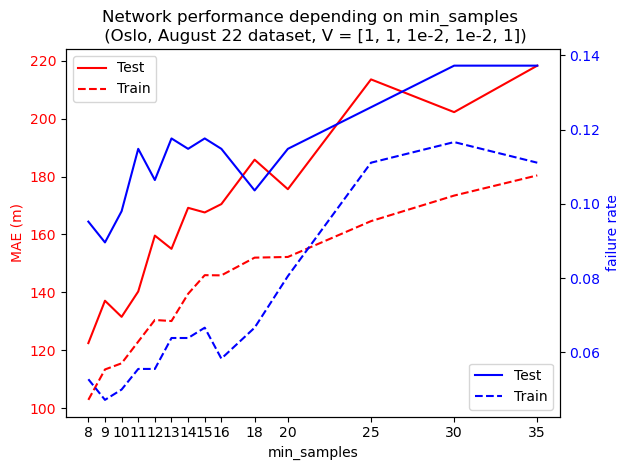

In [26]:
# DEPENDENCE: MIN_SAMPLES (Oslo)
eval_df.sort_values(by='min_samples', inplace=True)
filter_train = ((eval_df['n_points']==2173821) & (eval_df['V 5']==1) & (eval_df['V 3,4']==1e-2) & 
                (eval_df['algorithm']=='V7.0(SSPD)') & (eval_df['test_data/n_trajectories']==360))
filter_test = ((eval_df['n_points']==2173821) & (eval_df['V 5']==1) & (eval_df['V 3,4']==1e-2) & 
                (eval_df['algorithm']=='V7.0(SSPD)') & (eval_df['test_data/n_trajectories']==357))
x = eval_df[filter_train]['min_samples']

# configure axes
fig, ax1 = plt.subplots()
ax1.set_xlabel('min_samples')
ax1.set_ylabel('MAE (m)', color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax1.set_xticks(x)
ax2 = ax1.twinx()  
ax2.set_ylabel('failure rate', color='blue') 
ax2.tick_params(axis='y', labelcolor='blue')

y1_test = eval_df[filter_test]['Mean']
y2_test = 1-eval_df[filter_test]['success']
y1_train = eval_df[filter_train]['Mean']
y2_train = 1-eval_df[filter_train]['success']
ax1.plot(x, y1_test, color='red', label='Test')
ax2.plot(x, y2_test, color='blue', label='Test')
ax1.plot(x, y1_train, color='red', linestyle='--', label='Train')
ax2.plot(x, y2_train, color='blue', linestyle='--', label='Train')

# Add legend
ax1.legend(loc='upper left')
ax2.legend(loc='lower right')

plt.title('Network performance depending on min_samples \n (Oslo, August 22 dataset, V = [1, 1, 1e-2, 1e-2, 1])')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.show()

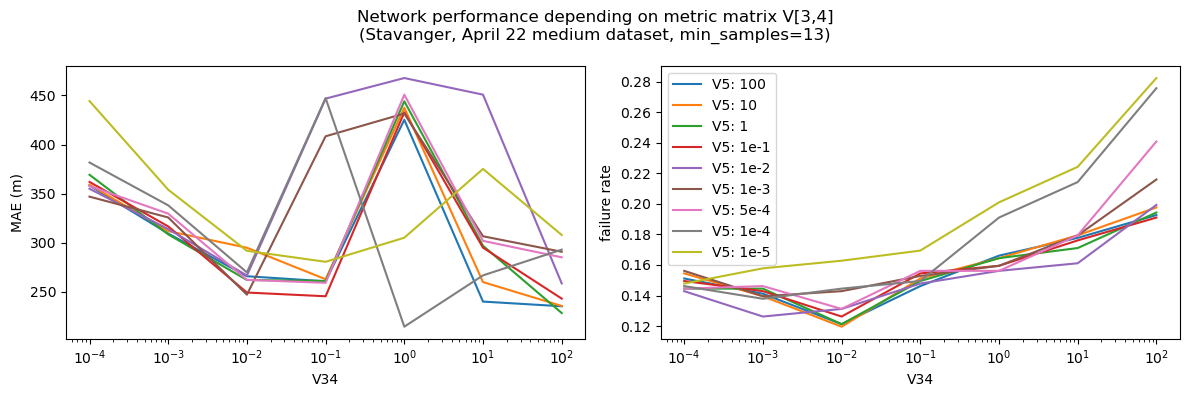

In [9]:
# DEPENDENCE: V 34
eval_df.sort_values(by='V 3,4', inplace=True)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # Set the figure size

# Plot on the first axis (axes[0])
axes[0].set_xlabel('V34')
axes[0].set_xscale('log')  # Corrected the x-scale
axes[0].set_ylabel('MAE (m)')
axes[0].tick_params(axis='y')

# Plot on the second axis (axes[1])
axes[1].set_xlabel('V34')  # Added x-label for the second plot
axes[1].set_xscale('log')  # Corrected the x-scale
axes[1].set_ylabel('failure rate') 
axes[1].tick_params(axis='y')

for val in [100, 10, 1, 1e-1, 1e-2, 1e-3, 5e-4, 1e-4, 1e-5]:
    filter = ((eval_df['n_points'] == 1794132) & (eval_df['V 5'] == val) & (eval_df['min_samples'] == 13) 
              & (eval_df['DP_tol']==10) & (eval_df['algorithm']=='V7.0(SSPD)') & (eval_df['pruning']==1) & (eval_df['max_distance']==10))
    x = eval_df[filter]['V 3,4']
    y1 = eval_df[filter]['Mean']
    y2 = 1-eval_df[filter]['success']
    axes[0].plot(x, y1)
    axes[1].plot(x, y2)

# add legend
legend_labels = [f'V5: {val}' for val in ['100', '10', '1', '1e-1', '1e-2', '1e-3', '5e-4', '1e-4', '1e-5']]
plt.legend(legend_labels)

# Add title
fig.suptitle('Network performance depending on metric matrix V[3,4]\n(Stavanger, April 22 medium dataset, min_samples=13)')

fig.tight_layout()  # Adjust layout
plt.savefig('V34.png')
plt.show()

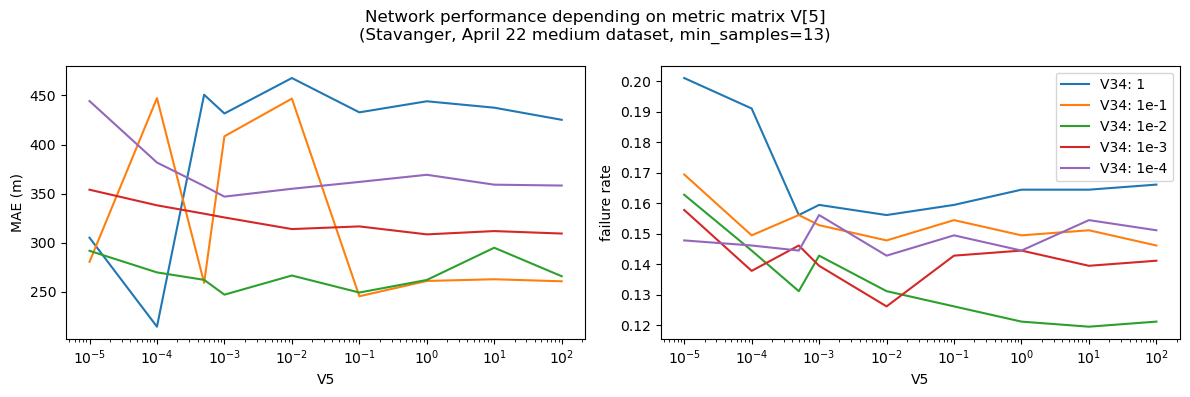

In [10]:
# DEPENDENCE: V 5
eval_df.sort_values(by='V 5', inplace=True)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # Set the figure size

# Plot on the first axis (axes[0])
axes[0].set_xlabel('V5')
axes[0].set_xscale('log')  # Corrected the x-scale
axes[0].set_ylabel('MAE (m)')
axes[0].tick_params(axis='y')

# Plot on the second axis (axes[1])
axes[1].set_xlabel('V5')  # Added x-label for the second plot
axes[1].set_xscale('log')  # Corrected the x-scale
axes[1].set_ylabel('failure rate') 
axes[1].tick_params(axis='y')

for val in [1, 1e-1, 1e-2, 1e-3, 1e-4]:
    filter = ((eval_df['n_points'] == 1794132) & (eval_df['V 3,4'] == val) & (eval_df['min_samples'] == 13) 
              & (eval_df['DP_tol']==10) & (eval_df['algorithm']=='V7.0(SSPD)') & (eval_df['pruning']==1) & (eval_df['max_distance']==10))
    x = eval_df[filter]['V 5']
    y1 = eval_df[filter]['Mean']
    y2 = 1-eval_df[filter]['success']
    axes[0].plot(x, y1)
    axes[1].plot(x, y2)

# add legend
legend_labels = [f'V34: {val}' for val in ['1', '1e-1', '1e-2', '1e-3', '1e-4']]
plt.legend(legend_labels)

# Add title
fig.suptitle('Network performance depending on metric matrix V[5]\n(Stavanger, April 22 medium dataset, min_samples=13)')

fig.tight_layout()  # Adjust layout
plt.savefig('V34.png')
plt.show()

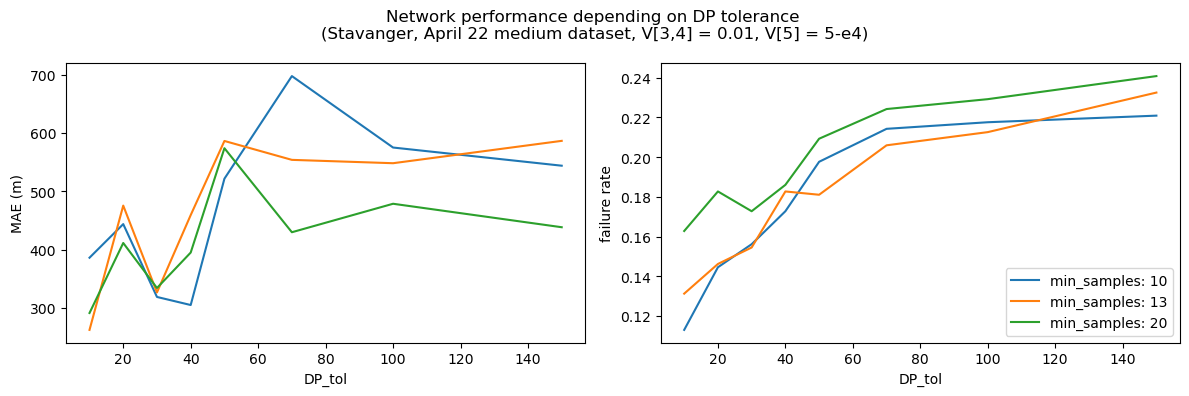

In [11]:
# DEPENDENCE: DP tolerance, medium dataset
eval_df.sort_values(by='DP_tol', inplace=True)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # Set the figure size

# Plot on the first axis (axes[0])
axes[0].set_xlabel('DP_tol')
axes[0].set_ylabel('MAE (m)')
axes[0].tick_params(axis='y')

# Plot on the second axis (axes[1])
axes[1].set_xlabel('DP_tol')  # Added x-label for the second plot
axes[1].set_ylabel('failure rate') 
axes[1].tick_params(axis='y')

for val in [10, 13, 20]:
    filter = ((eval_df['n_points'] == 1794132) & (eval_df['V 3,4'] == 0.01) & (eval_df['min_samples'] == val) & 
              (eval_df['V 5'] == 5e-4) & (eval_df['pruning']==1) & (eval_df['algorithm']=='V7.0(SSPD)'))
    x = eval_df[filter]['DP_tol']
    y1 = eval_df[filter]['Mean']
    y2 = 1-eval_df[filter]['success']
    axes[0].plot(x, y1)
    axes[1].plot(x, y2)

# add legend
legend_labels = [f'min_samples: {val}' for val in [10, 13, 20]]
plt.legend(legend_labels)

# Add title
fig.suptitle('Network performance depending on DP tolerance \n(Stavanger, April 22 medium dataset, V[3,4] = 0.01, V[5] = 5-e4)')

fig.tight_layout()  # Adjust layout
plt.show()

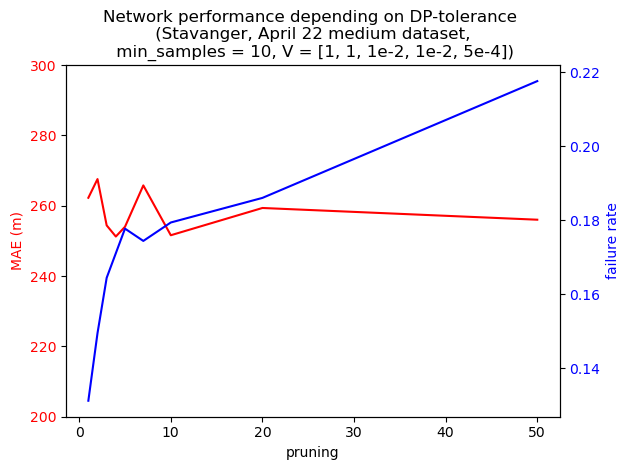

In [12]:
# DEPENDENCE on pruning
eval_df.sort_values(by='pruning', inplace=True)
fig, ax1 = plt.subplots()

ax1.set_xlabel('pruning')
ax1.set_ylabel('MAE (m)', color='red')
ax1.set_ylim([200, 300])
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()  
ax2.set_ylabel('failure rate', color='blue') 
ax2.tick_params(axis='y', labelcolor='blue')

for val in [13]:
    filter = ((eval_df['n_points']==1794132) & (eval_df['V 5']==5e-4) & (eval_df['V 3,4']==1e-2) & 
              (eval_df['min_samples']==val) & (eval_df['DP_tol']==10)) & (eval_df['algorithm']=='V7.0(SSPD)')
    x = eval_df[filter]['pruning']
    y1 = eval_df[filter]['Mean']
    y2 = 1-eval_df[filter]['success']
    ax1.plot(x, y1, color='red')
    ax2.plot(x, y2, color='blue')

plt.title('Network performance depending on DP-tolerance \n (Stavanger, April 22 medium dataset, \n min_samples = 10, V = [1, 1, 1e-2, 1e-2, 5e-4])')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.show()

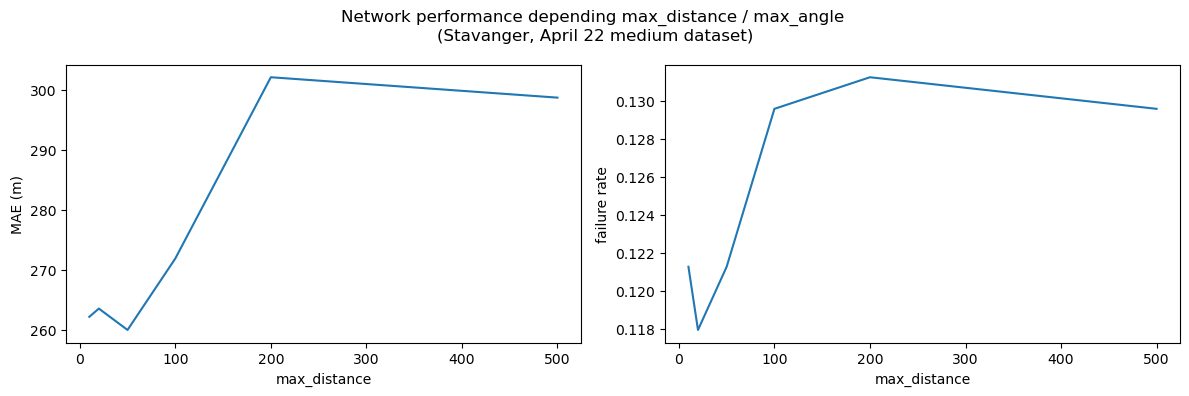

In [13]:
# DEPENDENCE on max_distance and max_angle
eval_df.sort_values(by='max_distance', inplace=True)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # Set the figure size

# Plot on the first axis (axes[0])
axes[0].set_xlabel('max_distance')
axes[0].set_ylabel('MAE (m)')
axes[0].tick_params(axis='y')

# Plot on the second axis (axes[1])
axes[1].set_xlabel('max_distance')  # Added x-label for the second plot
axes[1].set_ylabel('failure rate') 
axes[1].tick_params(axis='y')


filter = ((eval_df['n_points'] == 1794132) & (eval_df['V 3,4'] == 0.01) & (eval_df['min_samples'] == 13) & 
          (eval_df['DP_tol']==10) & (eval_df['V 5'] == 1) & (eval_df['algorithm']=='V7.0(SSPD)'))
x = eval_df[filter]['max_distance']
y1 = eval_df[filter]['Mean']
y2 = 1-eval_df[filter]['success']
axes[0].plot(x, y1)
axes[1].plot(x, y2)

# Add title
fig.suptitle('Network performance depending max_distance / max_angle \n(Stavanger, April 22 medium dataset)')
plt.savefig('dist_angle.png')
fig.tight_layout()  # Adjust layout
plt.show()

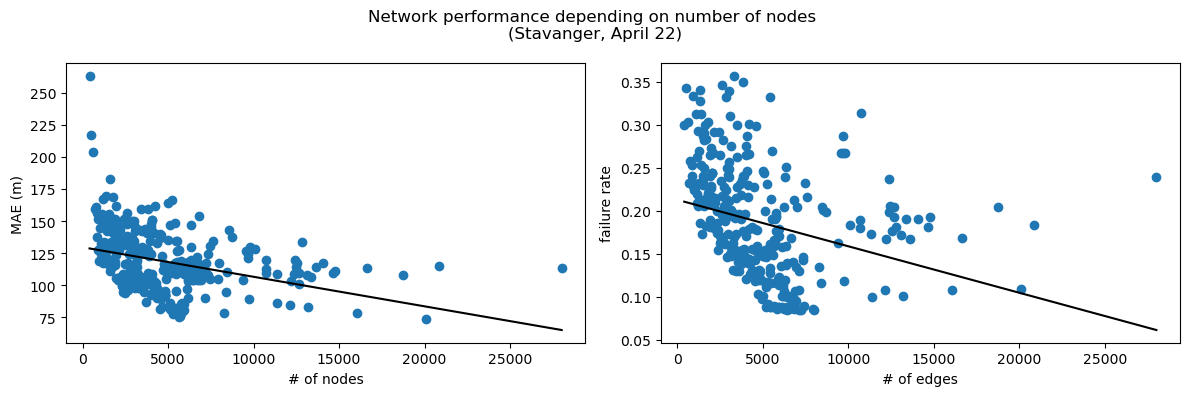

In [14]:
# DEPENDENCE between n_nodes and network quality
eval_df.sort_values(by='n_nodes', inplace=True)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # Set the figure size

# Plot on the first axis (axes[0])
axes[0].set_xlabel('# of nodes')
axes[0].set_ylabel('MAE (m)')
axes[0].tick_params(axis='y')

# Plot on the second axis (axes[1])
axes[1].set_xlabel('# of edges')  # Added x-label for the second plot
axes[1].set_ylabel('failure rate') 
axes[1].tick_params(axis='y')

filter = eval_df['n_points'].isin([448382.0, 1794132.0, 5422129.0])
x = eval_df[filter]['n_edges']
y1 = eval_df[filter]['Median']
y2 = 1-eval_df[filter]['success']
m, b = np.polyfit(x,y1,1)
axes[0].scatter(x, y1)
axes[0].plot(x, m*x+b, color='black')
m, b = np.polyfit(x,y2,1)
axes[1].scatter(x, y2)
axes[1].plot(x, m*x+b, color='black')

# Add title
fig.suptitle('Network performance depending on number of nodes \n(Stavanger, April 22)')

fig.tight_layout()  # Adjust layout
plt.show()

In [15]:
n = [5.4e6, 1.7e6, 0.8e6, 2.17e6]
f = [15, 10, 8]
for i in range(0, 4):
    rule = np.cbrt(n[i])/12
    print(rule)

14.62008869106433
9.945693266061141
7.735981389354632
10.788771586503051
